In [1]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../../scripts/")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from trajectory import Trajectory, load_trajectory_dict
from hivevo.patients import Patient
import filenames
import copy
from activity import get_average_activity

# Activity plots

## Functions

Format of the dictionnaries : trajectories[region][rev/non_rev/syn/non_syn]

In [2]:
def get_mean_in_time(trajectories, nb_bins=20, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-677, 3000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    nb_active = [len(freq) for freq in freqs]
    nb_dead = [fixed[ii] + lost[ii] for ii in range(len(fixed))]

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean, nb_active, nb_dead
    
    
    
def make_mean_in_time_dict(trajectories):
    regions = ["env", "pol", "gag", "all"]
    means = {}
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    times = []

    for freq_range in freq_ranges:
        means[str(freq_range)] = {}
        for region in regions:
            means[str(freq_range)][region] = {}
            for key in trajectories[region].keys():
                times, means[str(freq_range)][region][key], _, _ = get_mean_in_time(trajectories[region][key], freq_range=freq_range)
    return times, means, freq_ranges


def plot_mean_in_time(times, means, freq_ranges, savefig=None):
    regions = ["env", "pol", "gag"]
    colors = ["r", "b", "g"]
    fontsize=16
    fontsize2 = 20

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,10), sharex=True, sharey=True)
    for idx_row, split_type in enumerate([["rev", "non_rev"], ["syn", "non_syn"]]):
        for idx_col, region in enumerate(regions):
            for idx_colors,freq_range in enumerate(freq_ranges):
                axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[0]], f'{colors[idx_colors]}-')
                axs[idx_row, idx_col].plot(times, means[str(freq_range)][region][split_type[1]], f'{colors[idx_colors]}--')
                axs[idx_row, idx_col].grid()
                axs[idx_row, idx_col].set_ylim([-0.03, 1.03])
                if idx_row == 1:
                    axs[idx_row,idx_col].set_xlabel("Time [days]", fontsize=fontsize)
                if idx_col == 0:
                    axs[idx_row,idx_col].set_ylabel("Frequency", fontsize=fontsize)
                    axs[idx_row,idx_col].text(-0.3, 0.45, split_type[0], transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)
                if idx_row == 0:
                    axs[idx_row,idx_col].text(0.45, 1.1, region, transform=axs[idx_row,idx_col].transAxes, fontsize=fontsize2)

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    if savefig is not None:
        plt.savefig(savefig + ".pdf", format="pdf")

## Mean in time

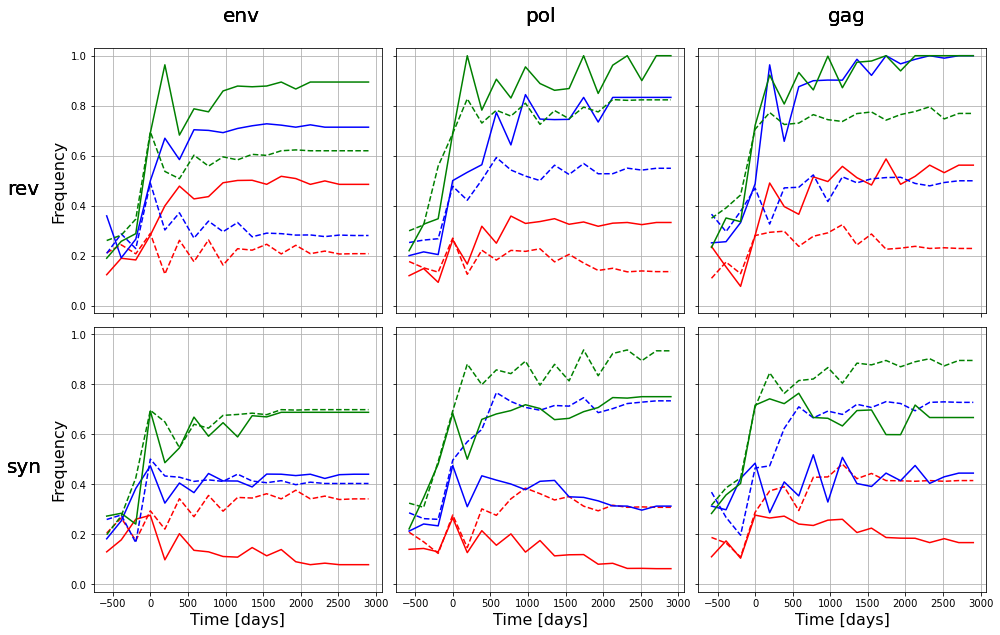

In [4]:
trajectories = load_trajectory_dict("../../trajectory_dict")
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
plot_mean_in_time(times, means, freq_ranges, savefig="Mean_in_time")

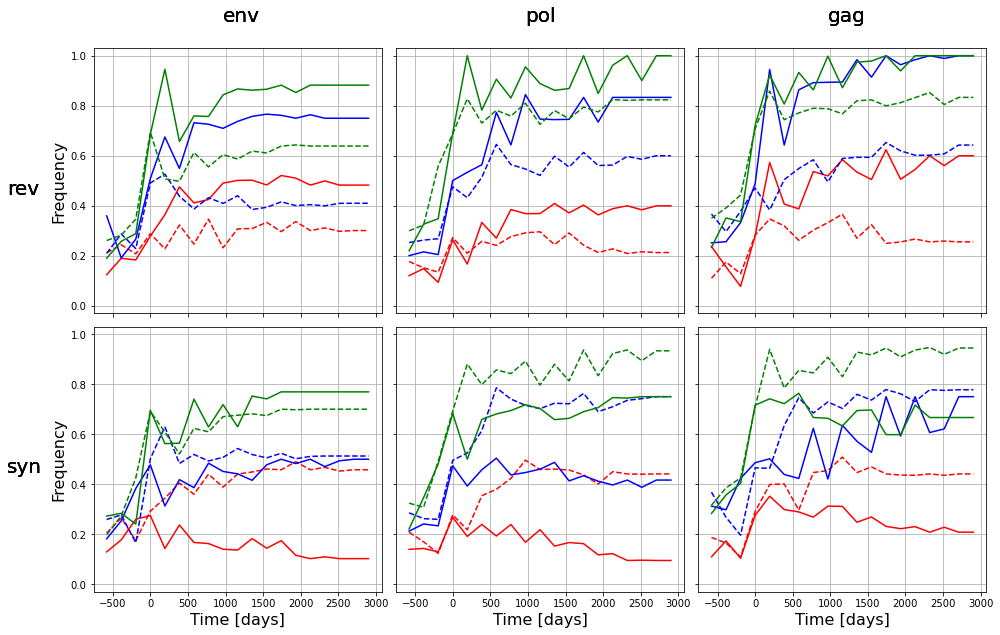

In [6]:
trajectories = make_trajectory_dict(remove_one_point=True)
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
plot_mean_in_time(times, means, freq_ranges)

# Plot 2

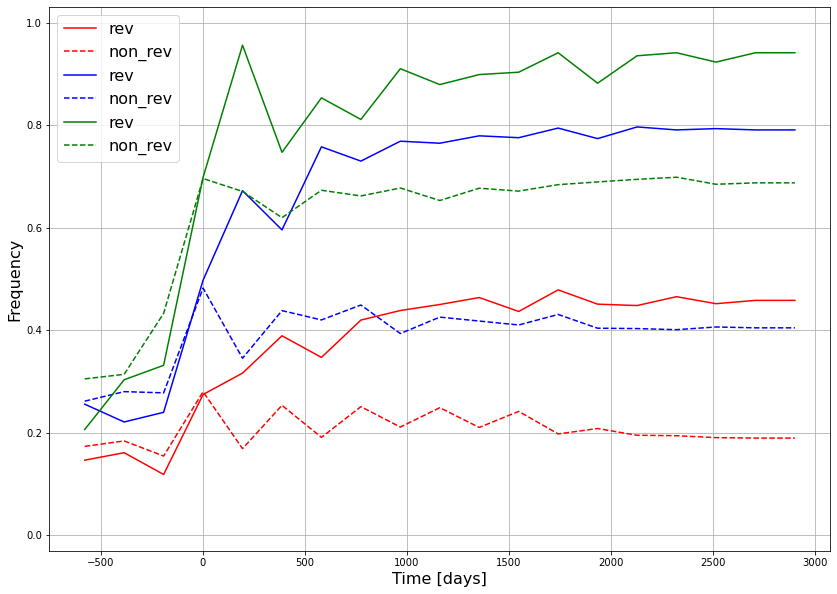

In [4]:
def plot_mean(times, means, savefig=False, fontsize=16):
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    colors = ["r","b","g"]
    
    plt.figure(figsize=(14,10))
    for ii, freq_range in enumerate(freq_ranges):
        plt.plot(times, means[str(freq_range)]["all"]["rev"], "-", color=colors[ii], label="rev")
        plt.plot(times, means[str(freq_range)]["all"]["non_rev"], "--", color=colors[ii], label="non_rev")

    plt.xlabel("Time [days]", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)
    plt.ylim([-0.03, 1.03])
    plt.grid()
    plt.legend(fontsize=fontsize)
    
    if savefig:
        plt.savefig(savefig+".pdf", format="pdf")
    plt.show()
    
    
trajectories = load_trajectory_dict("../../trajectory_dict")
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
plot_mean(times, means, savefig="Means_rev_VS_nonrev")

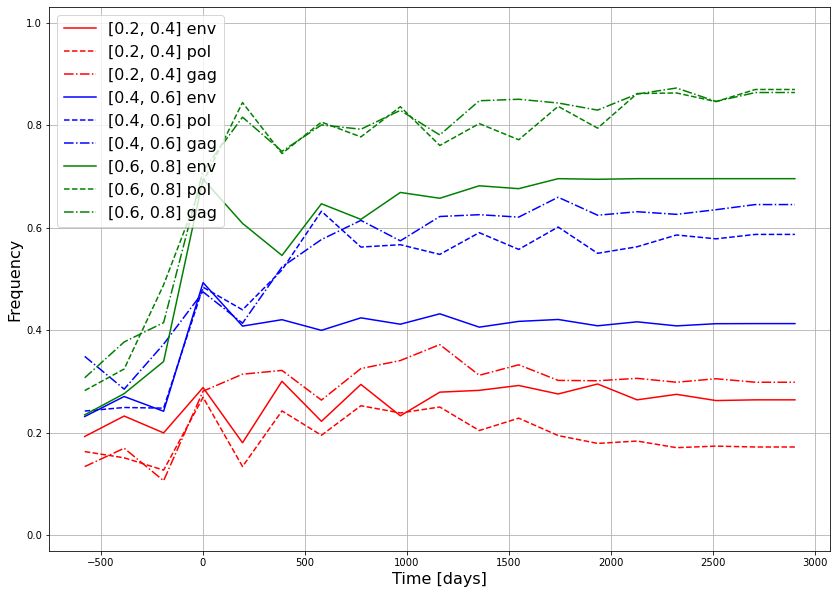

In [25]:
def plot_mean2(times, means, traj_type="all", savefig=False, fontsize=16):
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    regions = ["env","pol","gag"]
    colors = ["r","b","g"]
    lines = ["-","--","-."]

    plt.figure(figsize=(14,10))
    for ii, freq_range in enumerate(freq_ranges):
        for jj, region in enumerate(regions):
            plt.plot(times, means[str(freq_range)][region][traj_type], lines[jj], color=colors[ii], label= str(freq_range) + " " + region)

    plt.xlabel("Time [days]", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)
    plt.ylim([-0.03, 1.03])
    plt.grid()
    plt.legend(fontsize=fontsize)

    if savefig:
        plt.savefig(savefig+".pdf", format="pdf")
    plt.show()
    
plot_mean2(times, means, savefig="Means_alltraj_per_gene")

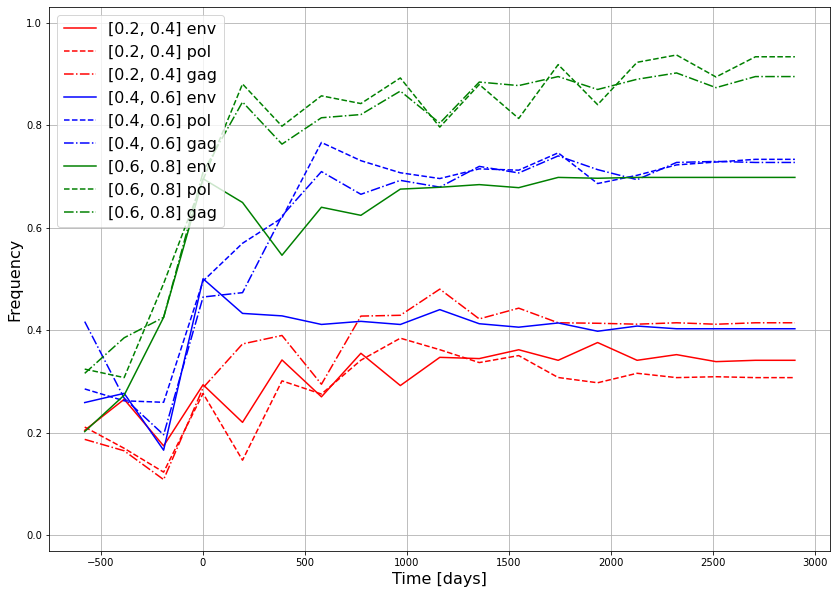

In [26]:
plot_mean2(times, means, traj_type="non_syn", savefig="Means_nonsyntraj_per_gene")